# Data Exploration

## Overview
This notebook performs data exploration and preprocessing for ground station data from Uniandes (Universidad de los Andes). The workflow includes data loading, quality control, temporal alignment, smoothing and clear-sky modeling.

## Key Operations

- CSV file reading and parsing
- Temporal alignment to 10-minute uniform UTC grid
- Basic Quality Control (QC) for GHI (Global Horizontal Irradiance)
- Negative value removal
- Physical ceiling clipping (1400 W/m²)
- Smoothing (Savitzky-Golay vs moving average)
- Clear-sky modeling using pvlib and k_ghi (clear-sky index)

## Libraries and Dependencies

In [31]:
# Core libraries
from __future__ import annotations  # Future compatibility
import os
from pathlib import Path
from dataclasses import dataclass
import numpy as np
import pandas as pd
from tqdm import tqdm  # Progress bars

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Signal processing
from scipy.signal import savgol_filter  # Savitzky-Golay smoothing

# Solar energy modeling
import pvlib  # Photovoltaic system modeling

## Data Source

In [32]:
df = pd.read_csv("../data_raw/datos_uniandes/datos_tierra.csv",
                          sep=";",
                          index_col=0,
                          parse_dates=True,
                          decimal=",")

## Preprocessing

- CSV Loading:
   - Semicolon-separated format
   - Index-based datetime parsing
   - Comma decimal separator handling
- Timezone Management:
   - Localize to "America/Bogota" if no timezone present
   - Convert to UTC for consistency
- Column Renaming: Simplified verbose original names to concise identifiers:
   - Humidity → "Hr"
   - Pressure → "p_hpa"
   - Wind direction → "wdir_deg"
   - Radiation → "ghi"
   - Temperature → "temp_c"
   - Wind speed → "wspd_ms"

In [33]:
if df.index.tz is None:
    df.index = df.index.tz_localize("America/Bogota")
else:
    df.index = df.index.tz_convert("America/Bogota")
df = df.tz_convert("UTC")

# Normaliza nombres de columnas (más cortos y claros)
rename_map = {
    "Sistema FV Andes 80kWp - Lufft WS501 BM: RS485-2 67 - Humedad relativa del aire 1 [%] - E_AH_REL1": "Hr",
    "Sistema FV Andes 80kWp - Lufft WS501 BM: RS485-2 67 - Presión relativa del aire 1 [hPa] - E_AP_REL1": "p_hpa",
    "Sistema FV Andes 80kWp - Lufft WS501 BM: RS485-2 67 - Dirección del viento [°] - E_W_D": "wdir_deg",
    "Sistema FV Andes 80kWp - Lufft WS501 BM: RS485-2 67 - Radiación [W/m²] - SRAD": "ghi",
    "Sistema FV Andes 80kWp - Lufft WS501 BM: RS485-2 67 - Temperatura [°C] - T": "temp_c",
    "Sistema FV Andes 80kWp - Lufft WS501 BM: RS485-2 67 - Velocidad del viento [m/s] - E_W_S": "wspd_ms",
}
df = df.rename(columns=rename_map).sort_index()

print(df.shape)
df.head()

(165312, 6)


,Hr,p_hpa,wdir_deg,ghi,temp_c,wspd_ms
Timestamp,,,,,,
2023-09-01 05:00:00+00:00,73.896,745.288,163.000,0.000,12.718,1.042
2023-09-01 05:05:00+00:00,74.888,745.184,108.532,0.000,12.292,2.858
2023-09-01 05:10:00+00:00,76.484,745.140,113.694,0.000,11.932,2.728
2023-09-01 05:15:00+00:00,76.674,745.032,110.576,0.144,12.132,2.300
2023-09-01 05:20:00+00:00,75.824,744.972,116.006,0.000,12.318,1.346


### Data Quality Assessment
- Temporal Range: Shows minimum and maximum timestamps
- Statistical Summary: Provides percentiles (1%, 5%, 50%, 95%, 99%) for data validation
- Null Analysis: Calculates percentage of missing values per variable
- Daily Coverage: Resamples data availability on daily basis

In [34]:
print("Rango temporal:", df.index.min(), "→", df.index.max())
print("\nDescripción (percentiles útiles):")
display(df.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).T)


nulls_pct = df.isna().mean().sort_values(ascending=False)*100
print("\n% nulos por variable:")
display(nulls_pct.to_frame("pct_nulls"))

# cov_daily = df.notna().resample("D").mean()*100
# cov_daily.tail()

Rango temporal: 2023-09-01 05:00:00+00:00 → 2025-03-28 04:55:00+00:00

Descripción (percentiles útiles):


,count,mean,std,min,1%,5%,50%,95%,99%,max
Hr,165147.0,71.699712,14.406764,15.272,35.26892,45.7746,73.878,91.9460,95.18400,99.804
p_hpa,165147.0,743.014925,1.314290,738.602,739.95892,740.7600,743.068,745.0520,745.67708,747.360
wdir_deg,165147.0,135.232888,48.982062,0.000,50.07320,79.9026,119.550,242.7708,284.26080,342.806
ghi,165147.0,173.209745,275.741277,0.000,0.00000,0.0000,1.960,833.5880,1083.02880,1448.416
temp_c,165147.0,15.756548,3.197444,7.302,10.02800,11.3000,15.176,21.5360,23.39800,27.272
wspd_ms,165147.0,1.732127,1.362863,0.000,0.16400,0.3000,1.248,4.3180,5.74800,14.474



% nulos por variable:


,pct_nulls
Hr,0.099811
p_hpa,0.099811
wdir_deg,0.099811
ghi,0.099811
temp_c,0.099811
wspd_ms,0.099811


### Temporal Resampling and Quality Control
- Resampling: 10-minute intervals using mean aggregation
-GHI Quality Control:

    - Clips negative values to 0

    - Caps maximum values at 1400 W/m² (physical limit)

In [35]:
FREQ = "10min"
df10 = df.resample(FREQ).mean()

In [36]:
df10[df10['ghi'] > 0]['ghi'].agg(['max', 'min'])

max    1400.169
min       0.001
Name: ghi, dtype: float64

In [37]:
if "ghi" in df10.columns:
    df10["ghi_qc"] = df10["ghi"].clip(lower=0, upper=1400)
else:
    raise KeyError("No se encontró la columna 'ghi' tras el renombrado.")

print(df10[["ghi", "ghi_qc"]].head())

                             ghi  ghi_qc
Timestamp                               
2023-09-01 05:00:00+00:00  0.000   0.000
2023-09-01 05:10:00+00:00  0.072   0.072
2023-09-01 05:20:00+00:00  0.000   0.000
2023-09-01 05:30:00+00:00  0.000   0.000
2023-09-01 05:40:00+00:00  0.000   0.000


### Visualization

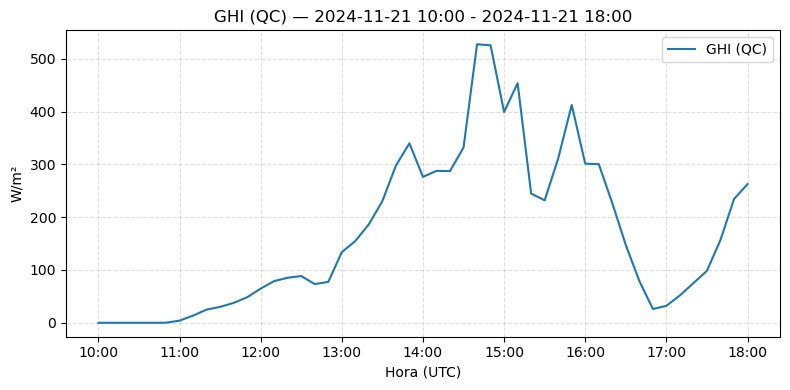

In [38]:
ini, fin = "2024-11-21 10:00", "2024-11-21 18:00"

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(df10.loc[ini:fin, "ghi_qc"], label="GHI (QC)")
ax.set_title(f"GHI (QC) — {ini} - {fin}")
ax.set_xlabel("Hora (UTC)"); ax.set_ylabel("W/m²")
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.grid(True, linestyle="--", alpha=0.4); ax.legend(); fig.tight_layout()
plt.show()

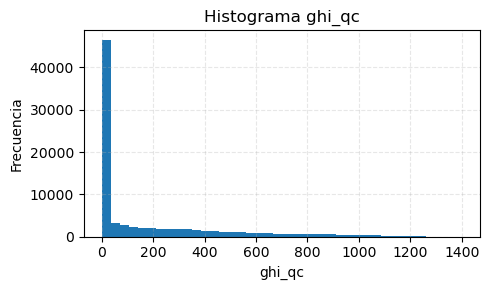

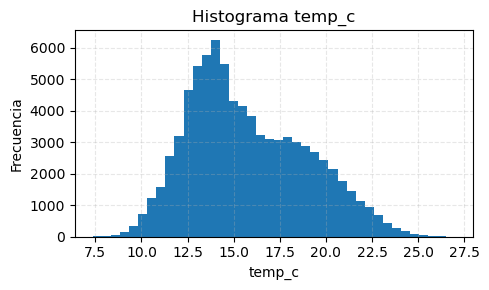

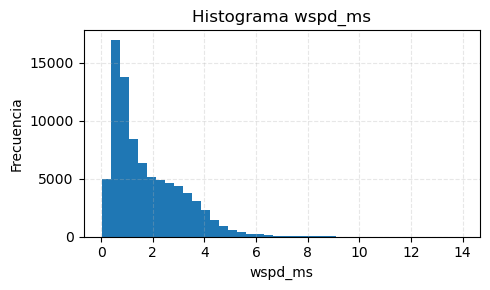

In [39]:
vars_hist = ["ghi_qc", "temp_c", "wspd_ms", "rh"]
for v in [c for c in vars_hist if c in df10.columns]:
    plt.figure(figsize=(5,3))
    df10[v].dropna().plot(kind="hist", bins=40)
    plt.title(f"Histograma {v}")
    plt.xlabel(v); plt.ylabel("Frecuencia")
    plt.grid(True, linestyle="--", alpha=0.3); plt.tight_layout()
    plt.show()

## Smoothing (Savitzky–Golay vs Moving Average)

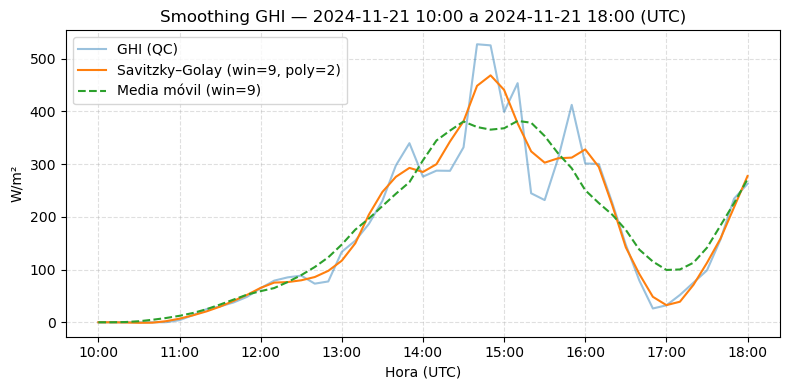

In [40]:
from scipy.signal import savgol_filter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Parámetros (10 min de muestreo → 9 muestras ≈ 90 min)
SG_WINDOW = 9      # debe ser impar y >= 3
SG_POLY   = 2      # orden del polinomio (1–3 suele bastar)
ROLL_WIN  = 9      # media móvil para comparar (misma ventana)

# Validaciones suaves
n = df10.shape[0]
if SG_WINDOW % 2 == 0:
    SG_WINDOW += 1
if SG_WINDOW > n:
    SG_WINDOW = max(3, (n // 2) * 2 + 1)  # impar <= n

# Interpola huecos cortos para estabilizar el filtro
y = df10["ghi_qc"].to_numpy(dtype="float64")
mask = np.isfinite(y)
y_interp = pd.Series(y).interpolate(limit_direction="both").to_numpy()

# Savitzky–Golay (centrado, NO causal)
y_sg = savgol_filter(y_interp, window_length=SG_WINDOW, polyorder=SG_POLY)
y_sg[~mask] = np.nan
df10["ghi_sg"] = y_sg

# Media móvil centrada (para comparar)
df10["ghi_roll"] = df10["ghi_qc"].rolling(ROLL_WIN, center=True, min_periods=1).mean()

# Plot comparativo en la misma ventana
ini, fin = "2024-11-21 10:00", "2024-11-21 18:00"
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(df10.loc[ini:fin, "ghi_qc"],   label="GHI (QC)", alpha=0.45)
ax.plot(df10.loc[ini:fin, "ghi_sg"],   label=f"Savitzky–Golay (win={SG_WINDOW}, poly={SG_POLY})")
ax.plot(df10.loc[ini:fin, "ghi_roll"], label=f"Media móvil (win={ROLL_WIN})", linestyle="--")

ax.set_title(f"Smoothing GHI — {ini} a {fin} (UTC)")
ax.set_xlabel("Hora (UTC)"); ax.set_ylabel("W/m²")
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.grid(True, linestyle="--", alpha=0.4); ax.legend(); fig.tight_layout()
plt.show()

### Final Smoothing

In [41]:
# Conservative parameters optimized for solar irradiance preservation
SG_WINDOW = 5      # 5 samples = 50 minutes (reduced from 9)
SG_POLY = 3        # Cubic polynomial (increased from 2)

# Validate parameters
if SG_WINDOW % 2 == 0:
    SG_WINDOW += 1  # Ensure odd window length
if SG_WINDOW > len(df10):
    SG_WINDOW = 3   # Fallback for very short series

In [42]:
# Only interpolate very short gaps to avoid creating artificial signals
MAX_INTERP_GAP = 3  # Max 3 consecutive missing values (30 min) to interpolate

y = df10["ghi_qc"].to_numpy(dtype="float64")
mask = np.isfinite(y)

In [43]:
y_series = pd.Series(y)
y_interp_limited = y_series.interpolate(
    method='linear',
    limit=MAX_INTERP_GAP,           # Only fill gaps ≤ 30 min
    limit_direction='both'
).to_numpy()

In [44]:
y_sg_conservative = savgol_filter(y_interp_limited, 
    window_length=SG_WINDOW, 
    polyorder=SG_POLY,
    mode='interp')

# Restore original NaN positions
y_sg_conservative[~mask] = np.nan
df10["ghi_sg_definitive"] = y_sg_conservative

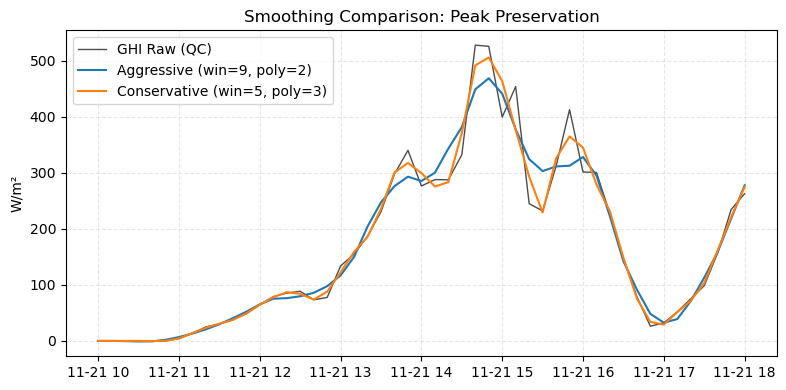

In [45]:
comparison_day = "2024-11-21" 
ini, fin = f"{comparison_day} 10:00", f"{comparison_day} 18:00"

fig, (ax1) = plt.subplots(figsize=(8,4))

ax1.plot(df10.loc[ini:fin, "ghi_qc"], label="GHI Raw (QC)", alpha=0.7, color='black', linewidth=1)
ax1.plot(df10.loc[ini:fin, "ghi_sg"], label=f"Aggressive (win=9, poly=2)", linewidth=1.5)
ax1.plot(df10.loc[ini:fin, "ghi_sg_definitive"], label=f"Conservative (win=5, poly=3)", linewidth=1.5)
ax1.set_title("Smoothing Comparison: Peak Preservation")
ax1.set_ylabel("W/m²")
ax1.legend()
ax1.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

In [46]:
df10.drop(columns=['ghi_sg', 'ghi_roll'], inplace=True)

## Clear-sky modeling (pvlib) & clear-sky index (k)

In [47]:
# Coordenadas aproximadas Uniandes 
LAT, LON, ALT_M = 4.6043, -74.0659, 2624.0   # Datos de Sanabria

# Asegurar UTC tz-aware
if df10.index.tz is None:
    df10.index = df10.index.tz_localize("UTC")
else:
    df10 = df10.tz_convert("UTC")

# Cielo despejado (Ineichen) vía Location.get_clearsky
loc = pvlib.location.Location(LAT, LON, tz="UTC", altitude=ALT_M)


cs = loc.get_clearsky(times=df10.index, model="ineichen")  # -> columns: ghi, dni, dhi
df10["ghi_cs"] = cs["ghi"]


# Índice de cielo despejado
eps = 1e-6
df10["k_ghi"] = df10["ghi_sg_definitive"] / (df10["ghi_cs"] + eps)
# Índice de cielo despejado (raw)
mask_day = df10["ghi_cs"] >= 50
df10["k_raw"] = (df10["ghi_qc"] / df10["ghi_cs"]).where(mask_day).clip(0, 2.0)

# Enmascara noche para análisis
k_day = df10.loc[mask_day, "k_ghi"].clip(0, 2.0)

print(
    "Cobertura k (horas con sol): "
    f"{100*k_day.notna().mean():.1f}% | "
    f"Q50={k_day.median():.2f}, Q95={k_day.quantile(0.95):.2f}"
)

Cobertura k (horas con sol): 99.9% | Q50=0.44, Q95=0.95


### Visual Diagnostic

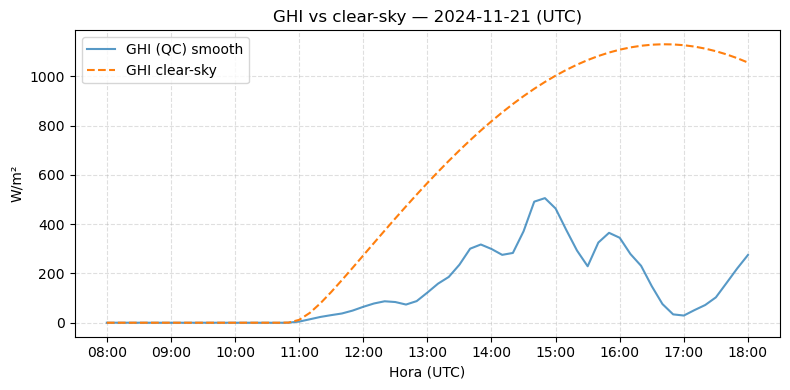

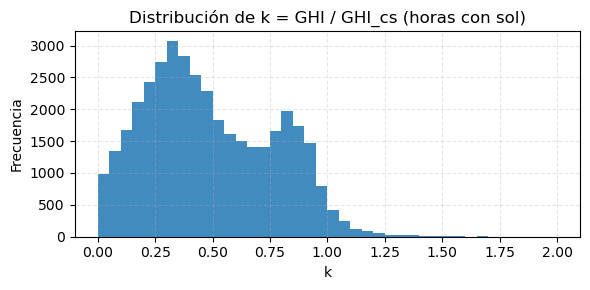

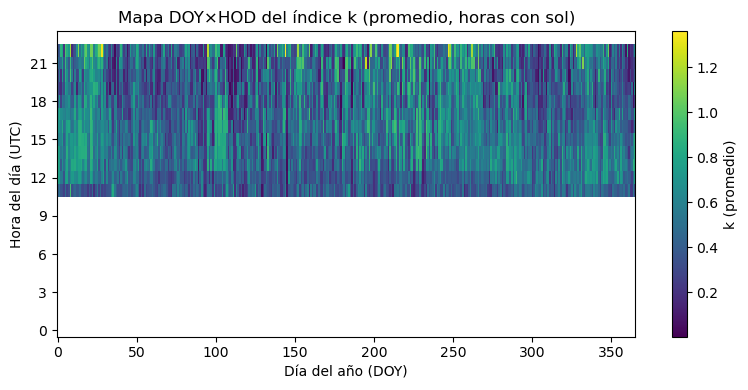

In [48]:
# A) Un día representativo
day = "2024-11-21"
ini, fin = f"{day} 08:00", f"{day} 18:00"

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(df10.loc[ini:fin, "ghi_sg_definitive"], label="GHI (QC) smooth", alpha=0.75)
ax.plot(df10.loc[ini:fin, "ghi_cs"], label="GHI clear-sky", linestyle="--")
ax.set_title(f"GHI vs clear-sky — {day} (UTC)")
ax.set_xlabel("Hora (UTC)"); ax.set_ylabel("W/m²")
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.grid(True, linestyle="--", alpha=0.4); ax.legend(); fig.tight_layout()
plt.show()

# B) Histograma de k en horas con sol
plt.figure(figsize=(6,3))
k_day.plot(kind="hist", bins=40, alpha=0.85)
plt.title("Distribución de k = GHI / GHI_cs (horas con sol)")
plt.xlabel("k"); plt.ylabel("Frecuencia"); plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout(); plt.show()

# C) Heatmap DOY×HOD del k promedio (usar el índice de la serie filtrada)
k = df10.loc[mask_day, "k_ghi"].clip(0, 2)

mat = (
    k.groupby([k.index.dayofyear, k.index.hour])  # <-- usar k.index, no df10.index
     .mean()
     .unstack(1)                                  # filas: DOY, columnas: HOD
     .reindex(columns=range(24))                  # asegurar 0..23
)

plt.figure(figsize=(8,4))
im = plt.imshow(mat.T, aspect="auto", origin="lower", interpolation="nearest")
plt.colorbar(im, label="k (promedio)")
plt.yticks(range(0,24,3), range(0,24,3))
plt.xlabel("Día del año (DOY)")
plt.ylabel("Hora del día (UTC)")
plt.title("Mapa DOY×HOD del índice k (promedio, horas con sol)")
plt.tight_layout()
plt.show()

### Quick Metrics vs. Clear-Sky Model

Excedencias GHI > 1.10 * GHI_cs: 400


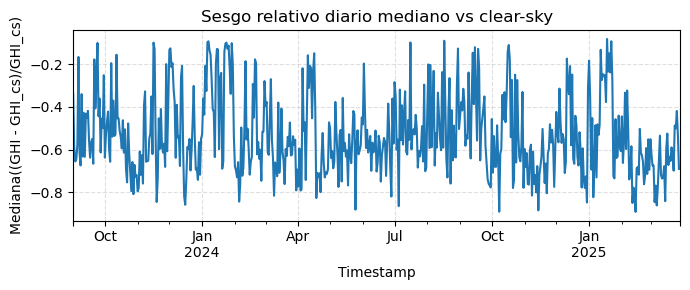

In [49]:
# Excedencias (edge-of-cloud): cuántas veces GHI supera al clear-sky por > X%
thr = 1.10  # 10% sobre clear-sky
exceed = (df10["ghi_sg_definitive"] > thr * df10["ghi_cs"]) & mask_day
print("Excedencias GHI > 1.10 * GHI_cs:", int(exceed.sum()))

# Sesgo relativo diario (útil para ver si el sensor/ajustes están corridos)
daily_rel_bias = (
    (df10["ghi_sg_definitive"] - df10["ghi_cs"]) / (df10["ghi_cs"] + eps)
).where(mask_day).resample("D").median()

ax = daily_rel_bias.plot(figsize=(7,3), title="Sesgo relativo diario mediano vs clear-sky")
ax.set_ylabel("Mediana((GHI - GHI_cs)/GHI_cs)"); ax.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout(); plt.show()


## Extended QC

In [50]:
# 
# df10["Hr"]      = df10["Hr"].clip(0,100)
# df10["temp_c"]  = df10["temp_c"].clip(-10,45)
# df10["wspd_ms"] = df10["wspd_ms"].clip(lower=0)
# df10["wdir_deg"]= (df10["wdir_deg"] % 360)
# df10["p_hpa"]   = df10["p_hpa"].clip(700,900)

df10["flag_night_ghi>5"] = (df10["ghi_cs"]<10) & (df10["ghi_sg_definitive"]>5)
df10["flag_spike"]       = df10["ghi_sg_definitive"].diff().abs() > 500  # cambios abruptos > 500 W/m² 

## Features

In [51]:
# ===== 2) Features sin fuga =====
# Tiempo cíclico
hod = df10.index.tz_convert("America/Bogota").hour
doy = df10.index.dayofyear
df10["hod_sin"], df10["hod_cos"] = np.sin(2*np.pi*hod/24), np.cos(2*np.pi*hod/24)
df10["doy_sin"], df10["doy_cos"] = np.sin(2*np.pi*doy/365), np.cos(2*np.pi*doy/365)

# Sol
solpos = pvlib.solarposition.get_solarposition(df10.index, 4.6043, -74.0659, 2624)
df10["zenith"] = solpos["apparent_zenith"].clip(0,90)
df10["azimuth"] = solpos["azimuth"]

# Viento a componentes
rad = np.deg2rad(df10["wdir_deg"])
df10["u_ms"] = -df10["wspd_ms"]*np.sin(rad)
df10["v_ms"] = -df10["wspd_ms"]*np.cos(rad)

# Punto de rocío
a,b = 17.62, 243.12
gamma = np.log(df10["Hr"].clip(1,100)/100) + (a*df10["temp_c"])/(b+df10["temp_c"])
df10["dewpoint_c"] = (b*gamma)/(a-gamma)

# Lags & rolling (solo pasado)
for col in ["k_ghi","ghi_qc","temp_c","u_ms","v_ms","dewpoint_c"]:
    if col in df10:
        for L in (1,2,3):
            df10[f"{col}_lag{L}"] = df10[col].shift(L)
        df10[f"{col}_roll_mean_1h"] = df10[col].rolling(6, min_periods=3).mean()
        df10[f"{col}_roll_std_1h"]  = df10[col].rolling(6, min_periods=3).std()

## Export

In [52]:
# ===== 3) Targets y export =====
H = [6,12,18,24,36]  # pasos de 10 min (hasta 6h)
for h in H:
    df10[f"y_k_raw_h{h}"]   = df10["k_raw"].shift(-h) # predecir k futuro crudo
    df10[f"y_k_h{h}"]   = df10["k_ghi"].shift(-h)     # predecir k futuro (normalizado)
    df10[f"y_ghi_h{h}"] = df10["ghi_qc"].shift(-h)    # o GHI futuro (W/m²)
    df10[f"y_ghi_sg_h{h}"] = df10["ghi_sg_definitive"].shift(-h)    # o GHI futuro (W/m²) Suavizado

feat_cols = [c for c in df10.columns if any(s in c for s in
    ["_lag", "_roll_", "hod_", "doy_", "zenith", "azimuth",
     "u_ms", "v_ms", "dewpoint_c", "Hr", "temp_c",
     "Hr", "p_hpa", "wspd_ms", "wdir_deg", "ghi_cs"])]

target_cols = [c for c in df10.columns
               if c.startswith(("y_k_raw_h","y_k_h","y_ghi_h","y_ghi_sg_h"))]

master = df10[feat_cols + target_cols].copy()

for c in master.columns:
    if master[c].dtype.kind in "fc":
        master[c] = master[c].astype("float32")

# Xy = df10[feat_cols + [target]].dropna()
Path("../data_interim").mkdir(parents=True, exist_ok=True)
master.to_parquet("../data_interim/ground_features.parquet", engine="pyarrow", compression="zstd")
print("ground_features.parquet | filas:", len(master), "| feats:", len(feat_cols), "| targets:", len(target_cols))


ground_features.parquet | filas: 82656 | feats: 45 | targets: 20


## Final Graphics

In [53]:
from pathlib import Path
FIG_DIR = Path("../reports/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

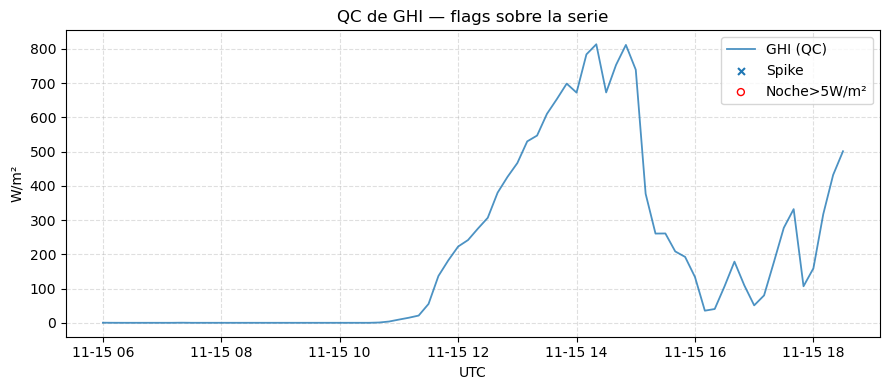

In [54]:
# Ventana de ejemplo (ajusta fechas)
ini, fin = "2024-11-15 06:00", "2024-11-15 18:30"

fig, ax = plt.subplots(figsize=(9,4))
ax.plot(df10.loc[ini:fin, "ghi_qc"], label="GHI (QC)", lw=1.3, alpha=0.8)

bad = df10.loc[ini:fin, "flag_spike"]
ax.scatter(df10.loc[ini:fin].index[bad], df10.loc[ini:fin, "ghi_qc"][bad],
           s=25, marker="x", label="Spike", zorder=3)

bad2 = df10.loc[ini:fin, "flag_night_ghi>5"]
ax.scatter(df10.loc[ini:fin].index[bad2], df10.loc[ini:fin, "ghi_qc"][bad2],
           s=25, marker="o", facecolors='none', edgecolors='r', label="Noche>5W/m²", zorder=3)

ax.set_title("QC de GHI — flags sobre la serie")
ax.set_xlabel("UTC"); ax.set_ylabel("W/m²")
ax.grid(True, ls="--", alpha=0.4); ax.legend()
fig.tight_layout()
# fig.savefig(FIG_DIR / "qc_flags_timeline.png", dpi=150)
plt.show()

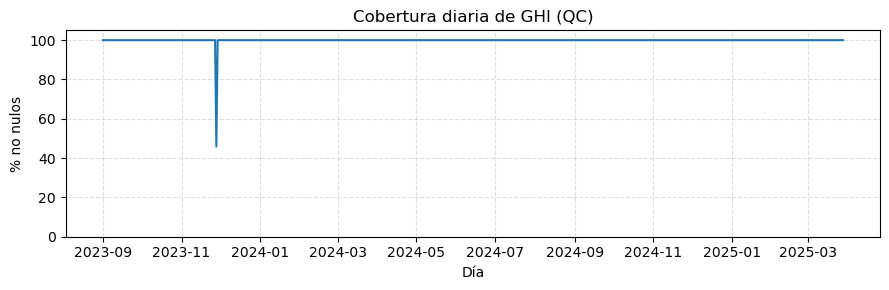

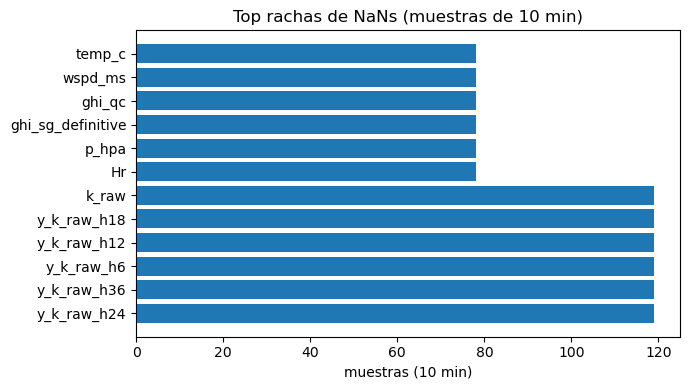

In [55]:
# Cobertura diaria (% no nulos)
cov_d = df10["ghi_qc"].notna().resample("D").mean()*100
fig, ax = plt.subplots(figsize=(9,3))
ax.plot(cov_d.index, cov_d.values)
ax.set_ylim(0, 105)
ax.set_title("Cobertura diaria de GHI (QC)")
ax.set_ylabel("% no nulos"); ax.set_xlabel("Día")
ax.grid(True, ls="--", alpha=0.4)
fig.tight_layout()
# fig.savefig(FIG_DIR / "cov_diaria_ghi.png", dpi=150)
plt.show()

# Racha máxima de NaNs (en muestras de 10 min) por variable
def max_racha_nans(s: pd.Series) -> int:
    m = s.isna().to_numpy()
    if not m.any(): return 0
    edges = np.diff(np.concatenate(([0], m.view(np.int8), [0])))
    starts = np.where(edges==1)[0]; ends = np.where(edges==-1)[0]
    return int((ends - starts).max()) if len(starts) else 0

rachas = {c: max_racha_nans(df10[c]) for c in df10.columns}
sr = pd.Series(rachas).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(7,4))
ax.barh(sr.index[:12], sr.values[:12])
ax.set_title("Top rachas de NaNs (muestras de 10 min)")
ax.set_xlabel("muestras (10 min)")
fig.tight_layout()
# fig.savefig(FIG_DIR / "rachas_nans_top.png", dpi=150)
plt.show()

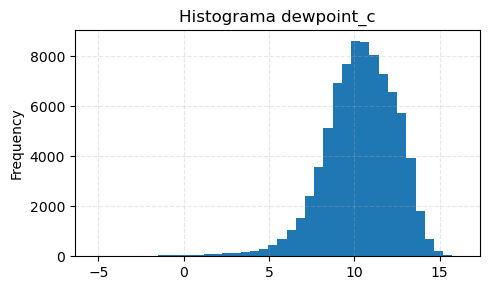

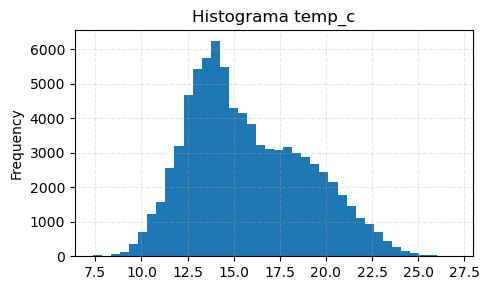

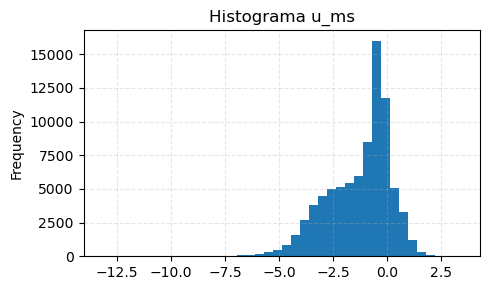

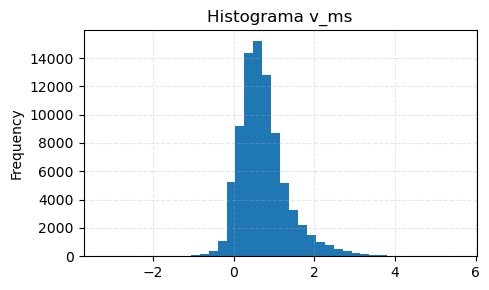

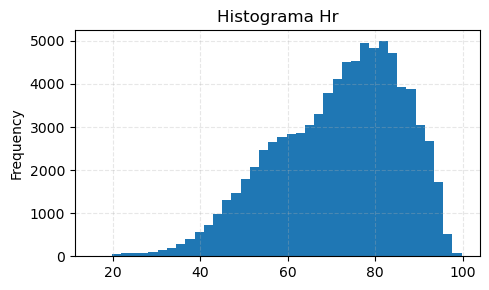

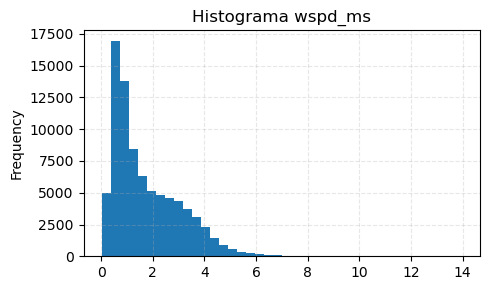

In [56]:
cols = [c for c in ["dewpoint_c","temp_c","u_ms","v_ms","Hr","wspd_ms"] if c in df10.columns]
for c in cols:
    plt.figure(figsize=(5,3))
    df10[c].dropna().plot(kind="hist", bins=40)
    plt.title(f"Histograma {c}")
    plt.grid(True, ls="--", alpha=0.3)
    plt.tight_layout()
    # plt.savefig(FIG_DIR / f"hist_{c}.png", dpi=130)
    plt.show()


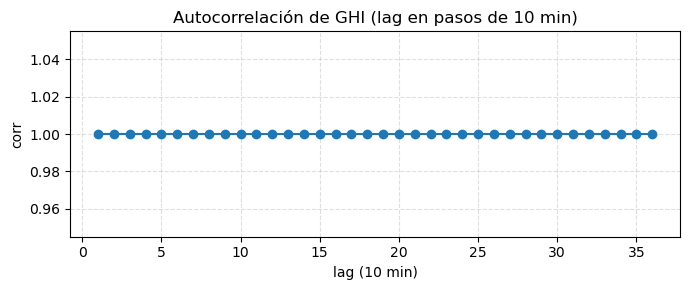

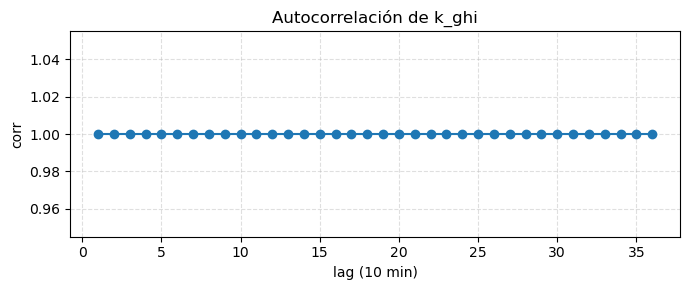

In [57]:
def corr_vs_lag(s: pd.Series, max_lag: int = 36):
    out = []
    x = s.to_numpy()
    for L in range(1, max_lag+1):
        a = s.iloc[:-L]; b = s.iloc[L:]
        out.append(a.corr(b))
    return np.array(out)

max_lag = 36  # hasta 6h si tu paso es 10 min
plt.figure(figsize=(7,3))
c = corr_vs_lag(df10["ghi_qc"].dropna(), max_lag)
plt.plot(np.arange(1, max_lag+1), c, marker="o")
plt.title("Autocorrelación de GHI (lag en pasos de 10 min)")
plt.xlabel("lag (10 min)"); plt.ylabel("corr")
plt.grid(True, ls="--", alpha=0.4); plt.tight_layout()
# plt.savefig(FIG_DIR / "acf_ghi.png", dpi=150); plt.show()
plt.show()

if "k_ghi" in df10:
    plt.figure(figsize=(7,3))
    c = corr_vs_lag(df10["k_ghi"].dropna(), max_lag)
    plt.plot(np.arange(1, max_lag+1), c, marker="o")
    plt.title("Autocorrelación de k_ghi")
    plt.xlabel("lag (10 min)"); plt.ylabel("corr")
    plt.grid(True, ls="--", alpha=0.4); plt.tight_layout()
    # plt.savefig(FIG_DIR / "acf_kghi.png", dpi=150); plt.show()
    plt.show()

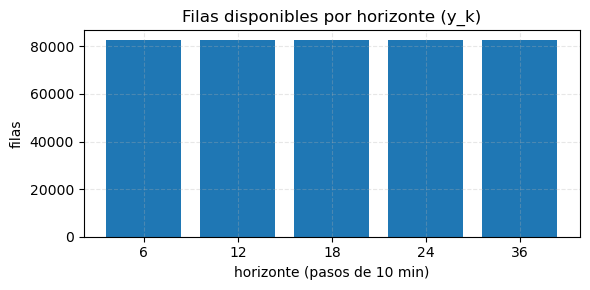

In [58]:
H = [6,12,18,24,36]  # igual a lo que generaste
disp = {h: df10[f"y_k_h{h}"].notna().sum() for h in H}
plt.figure(figsize=(6,3))
plt.bar([str(h) for h in H], [disp[h] for h in H])
plt.title("Filas disponibles por horizonte (y_k)")
plt.xlabel("horizonte (pasos de 10 min)"); plt.ylabel("filas")
plt.tight_layout()
plt.grid(True, ls="--", alpha=0.3)
# plt.savefig(FIG_DIR / "targets_disponibles.png", dpi=150)
plt.show()


Baseline persistencia (h=6): MAE=100763.452 | RMSE=461936.114


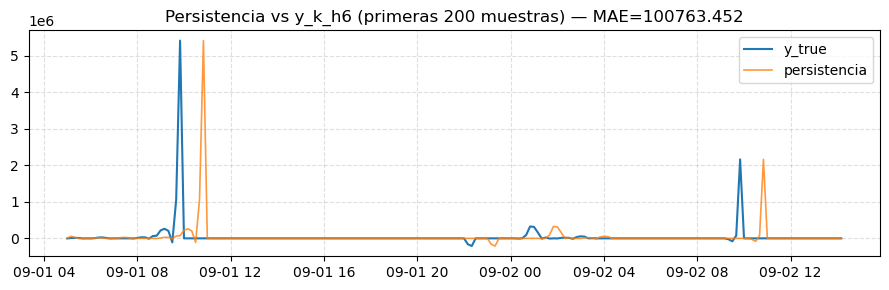

In [59]:
# El baseline "persistencia" predice y_k_h6 ≈ k_ghi (ahora)
h = 6
mask = df10[["k_ghi", f"y_k_h{h}"]].dropna().index
y_true = df10.loc[mask, f"y_k_h{h}"]
y_pred = df10.loc[mask, "k_ghi"]  # persistencia

mae = np.abs(y_true - y_pred).mean()
rmse = np.sqrt(((y_true - y_pred)**2).mean())
print(f"Baseline persistencia (h={h}): MAE={mae:.3f} | RMSE={rmse:.3f}")

plt.figure(figsize=(9,3))
plt.plot(y_true.index[:200], y_true.iloc[:200], label="y_true", lw=1.5)
plt.plot(y_pred.index[:200], y_pred.iloc[:200], label="persistencia", lw=1.2, alpha=0.8)
plt.title(f"Persistencia vs y_k_h{h} (primeras 200 muestras) — MAE={mae:.3f}")
plt.legend(); plt.grid(True, ls="--", alpha=0.4); plt.tight_layout()
# plt.savefig(FIG_DIR / f"baseline_persistencia_h{h}.png", dpi=150)
plt.show()


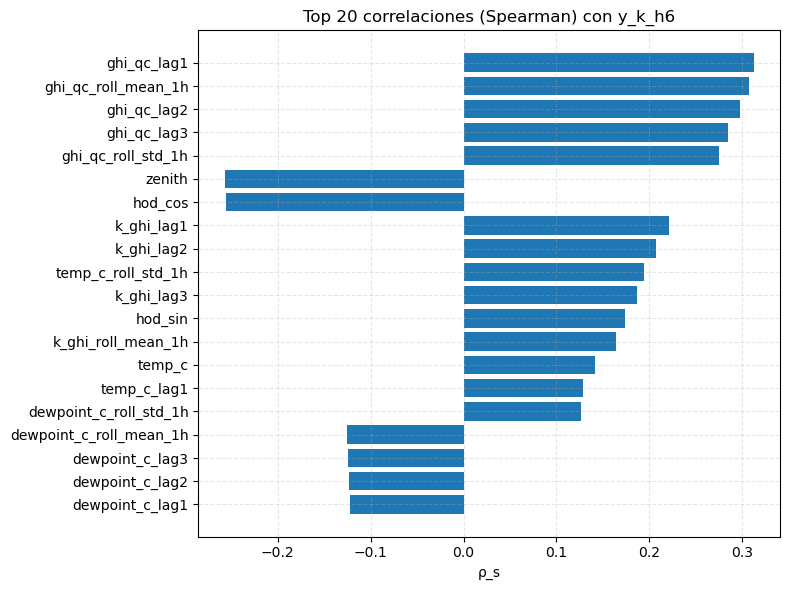

In [60]:
target = "y_k_h6"
feat_cols = [c for c in df10.columns if any(s in c for s in
             ["_lag","_roll_","hod_","doy_","zenith","azimuth","u_ms","v_ms","dewpoint_c","temp_c"])]

Xy = df10[feat_cols + [target]].dropna()
corrs = Xy.corr(method="spearman")[target].drop(labels=[target]).sort_values(key=np.abs, ascending=False)

topN = 20
fig, ax = plt.subplots(figsize=(8, max(4, 0.3*topN)))
ax.barh(corrs.index[:topN][::-1], corrs.values[:topN][::-1])
ax.set_title(f"Top {topN} correlaciones (Spearman) con {target}")
ax.set_xlabel("ρ_s"); ax.grid(True, ls="--", alpha=0.3)
fig.tight_layout()
# fig.savefig(FIG_DIR / f"corr_features_{target}.png", dpi=150)
plt.show()